[View in Colaboratory](https://colab.research.google.com/github/Chex-Mix/pneumonia-detection/blob/master/chest_x.ipynb)

# Chex Mix: Improving Pneumonia Detection by Considering Existing Disease Labels
Blake List and Daniel Bentall

## Abstract


In [1]:
# Import the necessary libraries to use the Google Drive directories.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download image data set using its ID.
image_df = drive.CreateFile({'id': '1If9W6LymNNJGEa2U_TfgWcsUBCV6_GoI'})
image_df.GetContentFile('balanced_resized.zip')

# Unzip the image folder.
!unzip -q 'balanced_resized.zip'

replace resized/00000003_000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# Import the necessary packages for preprocessing and plotting.
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


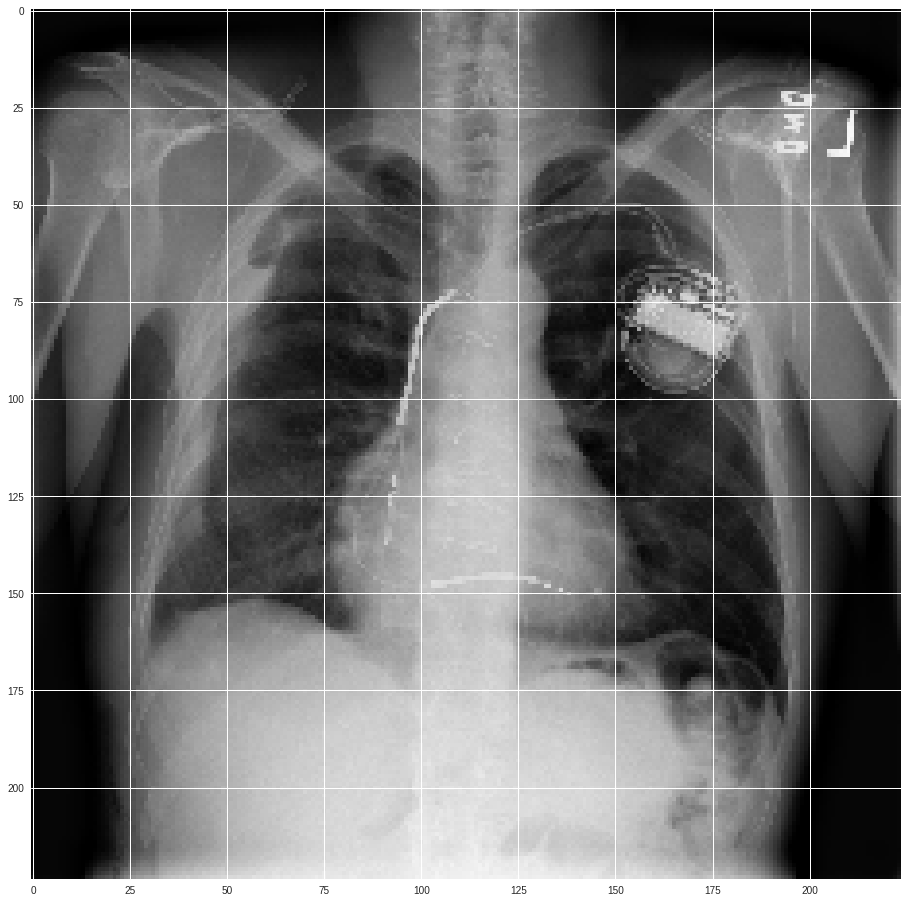

In [3]:
# Plot an image and its shape from the folder to see what it looks like
image = cv2.imread("resized/00000013_041.png")
im_shape = image.shape

plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

###Preprocessing of Metadata:
First we extracted the information about each image that was contained in a csv, including basic patient data like age and gender, and the thoracic diseases. This data had to be filtered to just the columns that were going to be used, so we created a subset to exclude any information regarding the view position or dimension of the images, as well as the patient ID. The labels of the thoracic diseases were split into individual columns of booleans of whether each disease was present in the image.


In [4]:
# Load in the label csv that includes the image index, thoracic pathologies and 
# basic patient information. Read in the dataframe and print it.
labels_data = drive.CreateFile({'id': '1SGohw8fB1J4QIRX2rr_uQa5158ZApqbk'})
labels_data.GetContentFile('balanced_resized_labels.csv')

with open('balanced_resized_labels.csv', 'r') as labels_df:
    labels_df = pd.read_csv('balanced_resized_labels.csv')
    
#labels_data = drive.CreateFile({'id': '1BRQMesGMIJuNBmHda2BHUs_F3izA8Ubt'})
#labels_data.GetContentFile('balanced_50_50_set_labels.csv')
#
#with open('balanced_50_50_set_labels.csv', 'r') as labels_df:
#  labels_df = pd.read_csv('balanced_50_50_set_labels.csv')
    
print(labels_df.head())

        Image Index             Finding Labels  Follow-up #  Patient ID  \
0  00014022_077.png                 No Finding           77       14022   
1  00014706_012.png  Cardiomegaly|Infiltration           12       14706   
2  00011460_032.png               Pneumothorax           32       11460   
3  00029259_010.png                  Emphysema           10       29259   
4  00012834_132.png         Pleural_Thickening          132       12834   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           66              M            AP                 2500     2048   
1           21              F            AP                 2500     2048   
2           16              M            PA                 2992     2991   
3           34              F            AP                 3056     2544   
4           33              M            AP                 2500     2048   

   OriginalImagePixelSpacing[x     y]  X12  
0                        0.168  0.168  Na

In [0]:
# Extract only the columns that are needed for the preprocessing of the 
# dataframe for the logistic model
df = labels_df.loc[:, ['Image Index', 'Patient Age', 'Patient Gender', 'Follow-up #']]

In [0]:
# Create a separate dataframe containing the labels column.
df_labs = labels_df.loc[:, ['Finding Labels']]

In [0]:
# Create a list of all the labels that will be extracted from the labels column.
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
          'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Nodule',
          'Pleural_Thickening', 'Cardiomegaly', 'Mass', 'Hernia']

In [0]:
# Create a function to extract each disease as a boolean for each row; True 
# where the disease is present in Finding Labels, False otherwise.
# Append it as its own column back to 'df' that will be used for the logistic.
def label_finder(label):
    df[label] = df_labs[df_labs['Finding Labels'].str.contains(label)]
    df[label] = df[label].notnull()

In [0]:
# Iterate over the list of labels and pass to the disease finder function.
for label in labels:
  label_finder(str(label))

In [0]:
# Convert the patient genders to booleans, where male is True.
df['Patient Gender'] = df['Patient Gender'] == 'M'

In [0]:
# Apply Sklearn's label encoder to convert the boolean columns from True/False 
# to 1/0.
df = df.select_dtypes(exclude=['object', 'number']).apply(LabelEncoder().fit_transform).join(df.select_dtypes(include=['object', 'number']))

In [12]:
# Print the dataframe so far. We can see that all diseases are in separate
# columns as booleans and all have been encoded to 1/0 for the logistic model.
print(df.head())

   Patient Gender  Atelectasis  Consolidation  Infiltration  Pneumothorax  \
0               1            0              0             0             0   
1               0            0              0             1             0   
2               1            0              0             0             1   
3               0            0              0             0             0   
4               1            0              0             0             0   

   Edema  Emphysema  Fibrosis  Effusion  Pneumonia  Nodule  \
0      0          0         0         0          0       0   
1      0          0         0         0          0       0   
2      0          0         0         0          0       0   
3      0          1         0         0          0       0   
4      0          0         0         0          0       0   

   Pleural_Thickening  Cardiomegaly  Mass  Hernia       Image Index  \
0                   0             0     0       0  00014022_077.png   
1                   0 

### Preprocessing of Image Data
Before being uploaded to the Google Colab environment, the images we downsized from 1024 x 1024 to 224 x 224. This was done to allow for smaller storage on the drive, and faster runtime. It was also the default size of the input shape to the DenseNet-121 convolutional neural network. The images were then read in and their image arrays were added as a column to the feature label dataframe. We obtained lists for the train and test sets containing the indices of the images used in the train-test split by CheXNet. It was important to include this in our method as it would separate any repeating patient images so that no two patients would appear in both the train and test sets, thus leading to an overfit model. We then merged these lists with the dataframe containing the patient data, disease labels and image arrays. For the purpose of validating the performance of the model, we split the train data into a train and validation set. This would be much smaller than the full train and test set sizes, but would allow us to quickly evaluate our model and adjust any parameters. The column featuring the ‘Pneumonia’ labels for each set was separated to form the response variable, while the remaining data became the predictors. The train validation split that was used to make decisions about the parameters of the model did not take into consideration possible data leakage from having different records from the same patient in the training and validation sets, so the validation scores may have been overly optimistic, however the final test scores do not suffer from this bias.

In [13]:
# Set the image size and input shape. Extract the image arrays and resize them 
# to the specified input shape then append them to a list.
img_size = 224

input_shape = (img_size, img_size, 3)

X = []

for image_filename in tqdm(df['Image Index']):       
  img_file = cv2.imread('resized' + '/' + image_filename)
  img_file = scipy.misc.imresize(arr=img_file, size=input_shape)
  img_arr = np.asarray(img_file)
  X.append(img_arr)

  0%|          | 0/29100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 29100/29100 [00:37<00:00, 767.91it/s]


In [0]:
# Convert the list of image arrays to a Pandas series and create a new column
# in the full dataframe with its values as the column elements.
X = pd.Series(X)
df['img_arr'] = X.values

In [15]:
# Print out the head of the data to see the format and type of each column and
# the shape of the dataframe.
print(df.head())
print(df.shape)

   Patient Gender  Atelectasis  Consolidation  Infiltration  Pneumothorax  \
0               1            0              0             0             0   
1               0            0              0             1             0   
2               1            0              0             0             1   
3               0            0              0             0             0   
4               1            0              0             0             0   

   Edema  Emphysema  Fibrosis  Effusion  Pneumonia  Nodule  \
0      0          0         0         0          0       0   
1      0          0         0         0          0       0   
2      0          0         0         0          0       0   
3      0          1         0         0          0       0   
4      0          0         0         0          0       0   

   Pleural_Thickening  Cardiomegaly  Mass  Hernia       Image Index  \
0                   0             0     0       0  00014022_077.png   
1                   0 

In [0]:
# Read in the list of train image indices from Google Drive and convert them 
# from a list to a dataframe.
labels_data = drive.CreateFile({'id': '1lRMSsJZXaJBl3ajhcK-oIs5KroyMFiQp'})
labels_data.GetContentFile('train_val_list.txt')

with open('train_val_list.txt', 'r') as f:
    train_index_list = [x.strip() for x in f.readlines()]
  
train_index_list = pd.DataFrame({'Image Index' : train_index_list})

In [0]:
# Read in the list of test image indices from Google Drive and convert them 
# from a list to a dataframe.
labels_data = drive.CreateFile({'id': '1P9xhlHs5aulb0UjsryjDmLdugGRC6lDu'})
labels_data.GetContentFile('test_list.txt')

with open('test_list.txt', 'r') as f:
    test_index_list = [x.strip() for x in f.readlines()]
  
test_index_list = pd.DataFrame({'Image Index' : test_index_list})

In [0]:
# Create a train and test dataframe containing both the label and image array 
# data split using the train and test index lists.
train = pd.merge(df, train_index_list, on='Image Index', how='inner')
test = pd.merge(df, test_index_list, on='Image Index', how='inner')

In [19]:
# Print out the shapes of the train and test dataframes.
print(train.shape)
print(test.shape)

(3504, 19)
(25596, 19)


In [0]:
# Shuffle the train and test data to remove any form of order.
#train = shuffle(train)
#test = shuffle(test)

In [0]:
# Train-test split the train data to create a validation set.
train, validate = train_test_split(train, test_size=0.3, random_state=5)

In [0]:
# Split the train and test data into feature and label sets. The label sets (y)
# will only contain the booleans for the 'Pneumonia' column.
X_train = train.drop(['Pneumonia'], axis=1)
X_test = test.drop(['Pneumonia'], axis=1)
y_train = train['Pneumonia']
y_test = test['Pneumonia']

In [0]:
# Split the validation data into feature and label sets. The label sets (y) will
# only contain the booleans for the 'Pneumonia' column.
X_validate = validate.drop(['Pneumonia'], axis=1)
y_validate = validate['Pneumonia']

In [0]:
# Use Keras to encode labels of the train, test and validation sets to one-hot 
# categorical vectors (e.g : 1 -> [0,1]).
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_validateHot = to_categorical(y_validate, num_classes = 2)

###Building, Training and Testing the Base Model CNN
The DenseNet-121 layer convolutional neural network was trained on the weights from the ImageNet dataset and used as the base model. This particular CNN was chosen as it was also used in CheXNet, the paper adopted as the case study for this project. Three densely connected layers were added to the top of the model; one being a layer of 8 fully connected nodes that would be used as the activations in the input to the logistic regression model, and another being a softmax layer with 2 nodes that would form the baseline classification of the CNN.

We defined custom metrics for F1 score, precision and recall that would be used to compile and train the model to be weighted towards the F1 score. Binary cross-entropy loss and adam were used as the loss function and optimizers. The model was first trained on the additional densely connected layers, with the base model frozen, then a section of the base model was unfrozen, from the top dense block onwards, and the model was retrained. A batch size of 16 and 10 epochs were used both times. The validation data was then used to predict the model on and the classification metrics were output, as well as sample images with the true labels and the labels from the prediction.


In [0]:
# Use Keras to build the base model by importing DenseNet-121 CNN pre-trained
# on weights from imagenet. Three fully connected layers were added including 
# the layer that would be extracted for activations and the softmax layer used
# for the basemodel classification. See https://keras.io/applications/
import keras
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras import optimizers
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# Create the base pre-trained model.
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer.
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add two fully-connected layers.
x = Dense(128, activation='relu')(x)
activations_layer = Dense(8, activation='relu')(x)

# Add a logistic layer for the output.
predictions = Dense(2, activation='softmax')(activations_layer)

# Define the model we will train.
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
#http://www.deepideas.net/unbalanced-classes-machine-learning/
# Define the custom metrics. F1 Score will be metric the model will be compiled
# with to be compared with the CheXNet.
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
  
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_predicited_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (total_predicited_positives + K.epsilon())
  
def f1_score(precision, recall):
    return 2*((precision*recall)/(precision+recall))

In [27]:
# Train only the top layers (which were randomly initialized) by freezing all 
# convolutional DenseNet121 layers.
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model with the loss, optimizer and custom metric functions.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
    weighted_metrics=[f1_score])

batch_size = 16
train_list = np.asarray(X_train['img_arr'].tolist())

# Train the model on the train data for for 10 epochs with a batch size of 16.
model.fit(np.asarray(X_train['img_arr'].tolist()), y_trainHot, batch_size=batch_size, epochs=10)

#datagen = tf.keras.preprocessing.image.ImageDataGenerator()
#datagen.fit(train_list)
#model.fit_generator(datagen.flow(train_list, y_trainHot, batch_size=batch_size), steps_per_epoch=(len(train_list)/batch_size), epochs=10)

Epoch 1/10
2452/2452 [==============================] - 25s 10ms/step - loss: 0.5805 - acc: 0.7296 - weighted_f1_score: 0.3692
Epoch 2/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.5311 - acc: 0.7443 - weighted_f1_score: 0.3791
Epoch 3/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.5185 - acc: 0.7435 - weighted_f1_score: 0.3826
Epoch 4/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.5001 - acc: 0.7557 - weighted_f1_score: 0.3867
Epoch 5/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.4754 - acc: 0.7741 - weighted_f1_score: 0.3927
Epoch 6/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.4533 - acc: 0.7863 - weighted_f1_score: 0.3974
Epoch 7/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.4233 - acc: 0.8091 - weighted_f1_score: 0.4043
Epoch 8/10
2452/2452 [==============================] - 20s 8ms/step - loss: 0.3857 - acc: 0.8361 - weighted_f1_score

In [28]:
# Visualize the layer names and layer indices to see how many layers should be 
# frozen.
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [0]:
# We will unfreeze the top dense block and keep the first 313 layers frozen.
for layer in model.layers[:313]:
   layer.trainable = False
for layer in model.layers[313:]:
   layer.trainable = True

In [0]:
# Recompile the model for these modifications to take effect.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
    weighted_metrics=[f1_score])

In [31]:
# Train the model on the train data for 10 epochs with batch size 16 again.
model.fit(np.asarray(X_train['img_arr'].tolist()), y_trainHot, batch_size=batch_size, epochs=10)

#datagen = tf.keras.preprocessing.image.ImageDataGenerator()
#datagen.fit(train_list)
#model.fit_generator(datagen.flow(train_list, y_trainHot, batch_size=batch_size), steps_per_epoch=(len(train_list)/batch_size), epochs=10)

# List all data in the history.
#print(history.history.keys())

# Plot accuracy and loss against epoch count.
#plt.plot(history.history['precision'])
#plt.plot(history.history['recall'])
#plt.title('Model Precision vs. Recall')
#plt.ylabel('Precision')
#plt.xlabel('Loss')
#plt.legend(['Precision', 'Recall'], loc='upper left')
#plt.show()

Epoch 1/10
2452/2452 [==============================] - 36s 14ms/step - loss: 0.6042 - acc: 0.7378 - weighted_f1_score: 0.3766
Epoch 2/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.4695 - acc: 0.7716 - weighted_f1_score: 0.3958
Epoch 3/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.3841 - acc: 0.8295 - weighted_f1_score: 0.4168
Epoch 4/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.3218 - acc: 0.8589 - weighted_f1_score: 0.4314
Epoch 5/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.2448 - acc: 0.9021 - weighted_f1_score: 0.4486
Epoch 6/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.2014 - acc: 0.9127 - weighted_f1_score: 0.4577
Epoch 7/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.1610 - acc: 0.9347 - weighted_f1_score: 0.4673
Epoch 8/10
2452/2452 [==============================] - 27s 11ms/step - loss: 0.1219 - acc: 0.9531 - weighted_f

              precision    recall  f1-score   support

No Pneumonia       0.75      0.42      0.54       804
   Pneumonia       0.23      0.55      0.32       248

 avg / total       0.63      0.45      0.49      1052



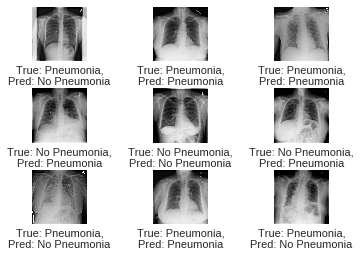

acc: 0.45


In [32]:
# Define the class labels and predict on the validation set. Then output the 
# predictions using Sklearn metrics and sample images of the validation data.
labels = ['No Pneumonia', 'Pneumonia']

input_shape = (img_size, img_size, 3)

#test_x = np.asarray(X_test['img_arr'].tolist())
validation = np.asarray(X_validate['img_arr'].tolist()) 
preds = model.predict(validation)
cls_pred = np.argmax(preds, axis=1)

# Print precision, recall, support and F1 score for the two classes.
print(sklearn.metrics.classification_report(y_validate, cls_pred, target_names=labels))

# Show the images.
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(input_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a 
    # single Notebook cell.
    plt.show()
      
# Plot the first nine images and their corresponding true and predicted labels.
plot_images(validation[0:9], np.argmax(y_validateHot[0:9], axis=1), cls_pred[0:9])

# Print the accuracy of the model.
print("acc: %.02f" % sklearn.metrics.accuracy_score(y_validate, cls_pred))

Average precision-recall score: 0.23


Text(0.5,1,'2-class Precision-Recall curve: AP=0.23')

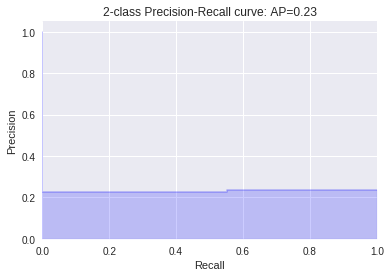

In [33]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_validate, cls_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_validate, cls_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

###Extracting Activations and Building the Logistic Model
Next, we extract the activations from the densely connected layer with 8 nodes after the model is predicted on the train and validation data. These activations will form part of the input to the logistic regression model. We then concatenate these activations with each of the train test and validation feature dataframes and drop any columns that will not be included in the logistic model, such as the image index or image array columns. A function is defined that will take as input, the logistic regression model from Sklearn, and the X and y train and test or validation sets. The function then computes the accuracy, precision, recall and F-1 score of the model to be compared with the baseline CNN results. Another final call is made to the logistic regression function that trains and tests on just the disease label and patient data, excluding the activations. This is done to confirm that the result of the logistic model trained and tested on the activations from the CNN is actually significant.

In [0]:
# Extract the activations from the second to last dense layer that has 8 nodes.
feature_layer = Model(inputs=model.input, outputs=model.get_layer('dense_2').output)

In [0]:
# Predict on the train, test and validation sets to get the activations of the 
# dense layer.
pool_features_train = feature_layer.predict(np.asarray(X_train['img_arr'].tolist()))
#pool_features_test = feature_layer.predict(np.asarray(X_test['img_arr'].tolist()))
pool_features_validate = feature_layer.predict(np.asarray(X_validate['img_arr'].tolist()))

In [0]:
# Convert the arrays of activations to dataframes to be concatenated to the rest
# of the data.
pool_features_train = pd.DataFrame(pool_features_train)
#pool_features_test = pd.DataFrame(pool_features_test)
pool_features_validate = pd.DataFrame(pool_features_validate)

In [0]:
# Drop the column of image arrays from the train data.
X_train = X_train.drop(['img_arr'], axis=1)
#X_test = X_test.drop(['img_arr'], axis=1)
X_validate = X_validate.drop(['img_arr'], axis=1)

In [0]:
# Concatenate the CNN layer activations with disease labels and patient data.
X_train_log = pd.concat([X_train.reset_index(drop=True), pool_features_train], axis=1)
#X_test_log = pd.concat([X_test.reset_index(drop=True), pool_features_test], axis=1)
X_validate_log = pd.concat([X_validate.reset_index(drop=True), pool_features_validate], axis=1)

In [0]:
# Drop the column containing the image indices from the feature sets.
X_train_log = X_train_log.drop(['Image Index'], axis=1)
#X_test_log = X_test_log.drop(['Image Index'], axis=1)
X_validate_log = X_validate_log.drop(['Image Index'], axis=1)

In [0]:
# Define the label sets for train, test and validation.
y_train_log = y_train
#y_test_log = y_test
y_validate_log = y_validate

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False): 0.792776
              precision    recall  f1-score   support

No Pneumonia       0.81      0.96      0.88       804
   Pneumonia       0.65      0.26      0.37       248

 avg / total       0.77      0.79      0.76      1052



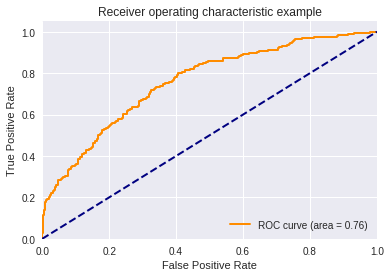

acc: 0.79
    Coefficients             Feature
0       0.135964      Patient Gender
1       0.849024         Atelectasis
2       0.392039       Consolidation
3       0.927259        Infiltration
4      -0.754764        Pneumothorax
5       2.128118               Edema
6       0.022439           Emphysema
7      -0.390777            Fibrosis
8       0.377223            Effusion
9       0.145279              Nodule
10     -0.213894  Pleural_Thickening
11      0.137875        Cardiomegaly
12      0.149382                Mass
13     -0.552395              Hernia
14     -0.007087         Patient Age
15      0.017954         Follow-up #
16      0.000000                   0
17     -0.101937                   1
18      0.011013                   2
19     -0.004240                   3
20      0.010470                   4
21      0.001342                   5
22      0.002787                   6
23      0.073692                   7


In [43]:
# Define a function which will be used to calculate the metrics of the logistic
# regression model and output its results as well as the coefficients of the 
# model.
def test_model(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  print("%s: %f" % (str(model), metrics.accuracy_score(y_test, y_predict)))
  print(metrics.classification_report(y_test, y_predict, target_names=labels))
  y_predict_proba = model.predict_proba(X_test)
  
  fpr, tpr, _ = metrics.roc_curve(y_test, y_predict_proba[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  
  print("acc: %.02f" % sklearn.metrics.accuracy_score(y_test, np.argmax(y_predict_proba, axis=1)))
    
  
  coefficients = pd.DataFrame({"Coefficients":np.transpose(model.coef_[0, ]), "Feature":X_train.columns})
  print(coefficients)
  
test_model(LogisticRegression(X_train_log, y_train_log, X_validate_log, y_validate_log))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False): 0.793726
              precision    recall  f1-score   support

No Pneumonia       0.81      0.96      0.88       804
   Pneumonia       0.66      0.26      0.37       248

 avg / total       0.77      0.79      0.76      1052



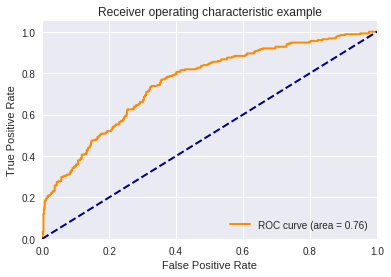

acc: 0.79
    Coefficients             Feature
0       0.116534      Patient Gender
1       0.848139         Atelectasis
2       0.385268       Consolidation
3       0.914075        Infiltration
4      -0.748623        Pneumothorax
5       2.118032               Edema
6       0.028672           Emphysema
7      -0.365476            Fibrosis
8       0.373368            Effusion
9       0.137545              Nodule
10     -0.223386  Pleural_Thickening
11      0.146880        Cardiomegaly
12      0.158268                Mass
13     -0.553242              Hernia
14     -0.007098         Patient Age
15      0.018214         Follow-up #


In [44]:
# Train and test the logistic regression model without any activations from the
# DenseNet-121 CNN.
X_logit_train = X_train.drop('Image Index', axis=1)
X_logit_validate = X_validate.drop('Image Index', axis=1)
  
test_model(LogisticRegression(X_logit_train, y_train_log, X_logit_validate, y_validate_log))